# CLTV

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_ = pd.read_excel('/Users/yelizsari/Downloads/VBO/VBO - Week 3/online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [3]:
df = df_.copy()

In [4]:
df.dropna(subset=['Customer ID'], inplace=True)

In [5]:
filt = df["Invoice"].str.contains("C")==True
df.drop(index=df[filt].index, inplace=True)

In [6]:
df['TotalPrice'] = df['Quantity'] * df['Price']

In [7]:
df = df[df['Country'] == 'United Kingdom']

# Model

In [8]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data

In [9]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"] = df["InvoiceDate"].apply(lambda t: t.date())
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

my_date = pd.to_datetime(['2011-12-11'])

In [10]:
# Create a DataFrame that is suitable for BG-NBD and Gamma-Gamma model

cltv = df.groupby('Customer ID').agg({
    'InvoiceDate': [
        lambda x: (x.max() - x.min()).days,  # recency
        lambda x: (my_date - x.min()).days  # T
    ],
    'Invoice': lambda x: x.nunique(),  # frequency
    'TotalPrice': lambda x: x.sum()  # monetary
})

cltv.columns = ['Recency', 'T', 'Frequency', 'Monetary']

# Get rid of the non-suitable monetary values for Gamma-Gamma model
cltv = cltv[cltv['Monetary'] >= 0]

# Calculate the average monetary values for Gamma-Gamma model
cltv['Monetary'] = cltv['Monetary'] / cltv['Frequency']

# Recency and tenure are calculated weekly in BG-NBD model
cltv['Recency'] = cltv['Recency'] / 7
cltv['T'] = cltv['T'] / 7

# Remove customers who appeared only one time
cltv = cltv[(cltv['Frequency'] > 1)]

# BG-NBD MODEL

In [11]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv['Frequency'], cltv['Recency'], cltv['T'])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.12, alpha: 11.76, b: 2.51, r: 2.22>

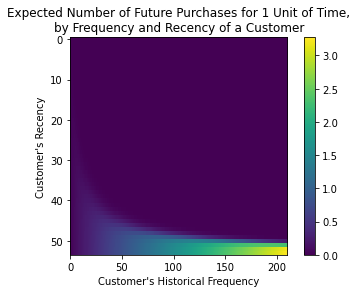

In [12]:
# We see that if a customer made purchase 120 times and 350 days old, then this customer is the best customer (at the right bottom).
# The customers who made a big purchase and not seen are at the right top.

plot_frequency_recency_matrix(bgf);

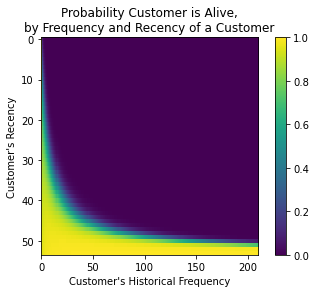

In [13]:
# Customers who made a lot of purchase and their recency is high, they can be called 'alive'.

plot_probability_alive_matrix(bgf);

In [14]:
# Since BG-NBD model is weekly, to calculate 6 months metrics t should be multiplied by 6.
# In the 'PredictedPurchases' column the expected purchases calculted for the next period.

t = 4 * 6
cltv['PredictedPurchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, cltv['Frequency'],
                                                                                    cltv['Recency'],
                                                                                    cltv['T'])
cltv.sort_values(by='PredictedPurchases').tail()

,Recency,T,Frequency,Monetary,PredictedPurchases
Customer ID,,,,,
15311.0,53.285714,53.571429,91,667.779121,33.522350
14606.0,53.142857,53.571429,93,130.716667,34.227460
13089.0,52.428571,53.000000,97,606.451856,35.955007
17841.0,53.142857,53.571429,124,330.577177,45.379874
12748.0,53.285714,53.571429,210,160.570143,76.358315


In [15]:
cltv['ExpectedPurchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, cltv['Frequency'],cltv['Recency'], cltv['T'])

# Gamma-Gamma MODEL

In [16]:
from lifetimes import GammaGammaFitter

In [17]:
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(cltv['Frequency'], cltv['Monetary'])

<lifetimes.GammaGammaFitter: fitted with 2570 subjects, p: 1.82, q: 4.24, v: 647.44>

In [18]:
ggf.conditional_expected_average_profit(cltv['Frequency'],
                                        cltv['Monetary']).head()

Customer ID
12747.0    378.909272
12748.0    162.275695
12749.0    698.598057
12820.0    274.924277
12822.0    422.015296
dtype: float64

In [19]:
print('Expected conditional average profit: %s, Average profit: %s' % 
      (ggf.conditional_expected_average_profit(cltv['Frequency'],
                                        cltv['Monetary']).mean(),
cltv[cltv['Frequency']>0]['Monetary'].mean()))

Expected conditional average profit: 386.79168837556625, Average profit: 397.16674124613087


In [20]:
cltv['Pred6Months'] = ggf.customer_lifetime_value(bgf # predicts the number of purchases for the future period
                            ,cltv['Frequency'],
                                   cltv['Recency'],
                                   cltv['T'],
                                   cltv['Monetary'],
                                   time=6,  # 6 months 
                                freq = 'M',
                                   discount_rate=0.01)

In [21]:
ggf.customer_lifetime_value(bgf # predicts the number of purchases for the future period
                            ,cltv['Frequency'],
                                   cltv['Recency'],
                                   cltv['T'],
                                   cltv['Monetary'],
                                   time=6,  # 6 months 
                                freq = 'M',
                                   discount_rate=0.01).sum()

955045.9874339511

### For 1 Month

In [22]:
cltv['Pred1Month'] = ggf.customer_lifetime_value(bgf # predicts the number of purchases for the future period
                            ,cltv['Frequency'],
                                   cltv['Recency'],
                                   cltv['T'],
                                   cltv['Monetary'],
                                   time=1,  # 12 months 
                                freq = 'W',
                                   discount_rate=0.01)
cltv.sort_values(by='Pred1Month', ascending=False).head(10).round(2)

,Recency,T,Frequency,Monetary,PredictedPurchases,ExpectedPurchases,Pred6Months,Pred1Month
Customer ID,,,,,,,,
16446.0,29.29,29.57,2,84236.25,2.29,2.29,25342.67,18855.88
18102.0,52.43,52.71,60,4327.62,22.65,22.65,23379.50,17378.74
17450.0,51.29,52.71,46,4229.36,17.47,17.47,17484.71,12997.00
14096.0,13.86,14.71,17,3833.22,16.50,16.50,14384.20,10711.70
17511.0,53.00,53.57,31,2937.50,11.91,11.91,8160.82,6066.16
16000.0,0.00,0.57,3,4131.23,9.08,9.08,6300.94,4707.37
16684.0,50.57,51.43,28,2380.48,11.18,11.18,6191.72,4602.69
13694.0,52.86,53.57,50,1300.79,18.74,18.74,5821.70,4327.39
15311.0,53.29,53.57,91,667.78,33.52,33.52,5434.66,4039.67


### For 12 Months

In [23]:
cltv['Pred12Months'] = ggf.customer_lifetime_value(bgf # predicts the number of purchases for the future period
                            ,cltv['Frequency'],
                                   cltv['Recency'],
                                   cltv['T'],
                                   cltv['Monetary'],
                                   time=12,  # 12 months 
                                freq = 'M',
                                   discount_rate=0.01)
cltv.sort_values(by='Pred12Months', ascending=False).head(10).round(2)

,Recency,T,Frequency,Monetary,PredictedPurchases,ExpectedPurchases,Pred6Months,Pred1Month,Pred12Months
Customer ID,,,,,,,,,
16446.0,29.29,29.57,2,84236.25,2.29,2.29,25342.67,18855.88,48822.84
18102.0,52.43,52.71,60,4327.62,22.65,22.65,23379.50,17378.74,45182.82
17450.0,51.29,52.71,46,4229.36,17.47,17.47,17484.71,12997.00,33790.24
14096.0,13.86,14.71,17,3833.22,16.50,16.50,14384.20,10711.70,27634.83
17511.0,53.00,53.57,31,2937.50,11.91,11.91,8160.82,6066.16,15771.82
16000.0,0.00,0.57,3,4131.23,9.08,9.08,6300.94,4707.37,11991.39
16684.0,50.57,51.43,28,2380.48,11.18,11.18,6191.72,4602.69,11964.38
13694.0,52.86,53.57,50,1300.79,18.74,18.74,5821.70,4327.39,11251.49
15311.0,53.29,53.57,91,667.78,33.52,33.52,5434.66,4039.67,10503.69


In [24]:
cltv['Segments'] = pd.qcut(cltv['Pred6Months'] ,4,['D','C','B','A'])
cltv

,Recency,T,Frequency,Monetary,PredictedPurchases,ExpectedPurchases,Pred6Months,Pred1Month,Pred12Months,Segments
Customer ID,,,,,,,,,,
12747.0,52.428571,53.000000,11,381.455455,4.751075,4.751075,441.167038,327.946347,852.479698,A
12748.0,53.285714,53.571429,210,160.570143,76.358315,76.358315,3034.720747,2255.747273,5865.363742,A
12749.0,30.000000,30.714286,5,818.176000,3.879580,3.879580,668.757267,497.503605,1289.016486,A
12820.0,46.142857,46.857143,4,235.585000,2.432873,2.432873,164.229702,122.107185,317.124368,C
12822.0,2.428571,12.714286,2,474.440000,2.954141,2.954141,311.524252,232.108346,597.528742,B
...,...,...,...,...,...,...,...,...,...,...
18272.0,34.857143,35.428571,6,513.096667,3.998971,3.998971,471.507340,350.688557,909.471632,A
18273.0,36.428571,37.000000,3,68.000000,2.432641,2.432641,106.660949,79.330439,205.731549,D
18282.0,17.000000,18.285714,2,89.025000,3.108007,3.108007,168.677098,125.599694,324.151525,C


In [25]:
cltv.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,2570.0,28.619622,16.245526,0.000000e+00,14.428571,30.000000,42.714286,53.285714
T,2570.0,37.220901,14.742867,5.714286e-01,28.321429,40.714286,51.428571,53.571429
Frequency,2570.0,5.952529,8.412724,2.000000e+00,2.000000,4.000000,6.000000,210.000000
Monetary,2570.0,397.166741,1726.042164,3.450000e+00,189.525703,294.267500,421.255417,84236.250000
PredictedPurchases,2570.0,3.616143,3.237585,6.553458e-24,1.962415,2.959817,4.407057,76.358315
ExpectedPurchases,2570.0,3.616143,3.237585,6.553458e-24,1.962415,2.959817,4.407057,76.358315
Pred6Months,2570.0,371.613225,939.752894,2.709062e-22,144.211289,232.928504,381.703197,25342.671298
Pred1Month,2570.0,276.468688,698.949775,2.013716e-22,107.292459,173.271175,283.775981,18855.880858
Pred12Months,2570.0,716.203830,1812.792513,5.235638e-22,278.075270,449.612061,734.805824,48822.842782


In [26]:


cltv.groupby('Segments').agg({'Recency':['min','max','mean'],
                             'Frequency':['min','max','mean'],
                             'T':['min','max','mean'],
                             'Monetary':['min','max','mean'],
                             'Pred6Months':['min','max','mean'],
                             'ExpectedPurchases':['min','max','mean']}).T


Segments                           D            C            B             A
Recency           min   0.000000e+00     0.000000     0.000000      0.000000
                  max   5.300000e+01    53.000000    52.857143     53.285714
                  mean  2.321417e+01    31.220961    29.053850     30.994224
Frequency         min   2.000000e+00     2.000000     2.000000      2.000000
                  max   3.400000e+01    39.000000    22.000000    210.000000
                  mean  2.892691e+00     3.937695     5.395639     11.580093
T                 min   1.585714e+01     5.857143     1.714286      0.571429
                  max   5.357143e+01    53.571429    53.571429     53.571429
                  mean  4.289336e+01    38.474410    33.682688     33.829593
Monetary          min   9.140000e+00     3.450000    34.150000     75.772500
                  max   1.625535e+03  1653.033333  1012.225000  84236.250000
                  mean  2.114737e+02   280.856952   339.936507    756.129960
Pred6Months       min   2.709062e-22   144.244522   233.151798    381.795386
                  max   1.442002e+02   232.705210   381.426628  25342.671298
                  mean  8.734126e+01   185.749029   300.010923    912.951272
ExpectedPurchases min   6.553458e-24     0.594123     1.492893      0.246213
                  max   3.743372e+00    14.526363    10.280558     76.358315
                  mean  1.405616e+00     2.667682     3.829813      6.560320